# Cargar y preprocesar imágenes

In [14]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


IMAGE_SIZE = 180
BATCH_SIZE = 32
CHANNELS = 3 # todavia no se que es esto
EPOCHS = 50 # ya se vera cual es el numero correcto // habia que hacer un rico for para ver que numero es

## Separamos las fotos en imagenes de entrenamiento (80%) y validación (20%) 

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Aves seleccionadas",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
   "Aves seleccionadas",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 1705 files belonging to 8 classes.
Using 1364 files for training.
Found 1705 files belonging to 8 classes.
Using 341 files for validation.


In [16]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['Alcedo atthis',
 'Alopochen aegyptiaca',
 'Branta canadensis',
 'Ciconia ciconia',
 'Fulica atra',
 'Himantopus himantopus',
 'Myiopsitta monachus',
 'Psittacula krameri']

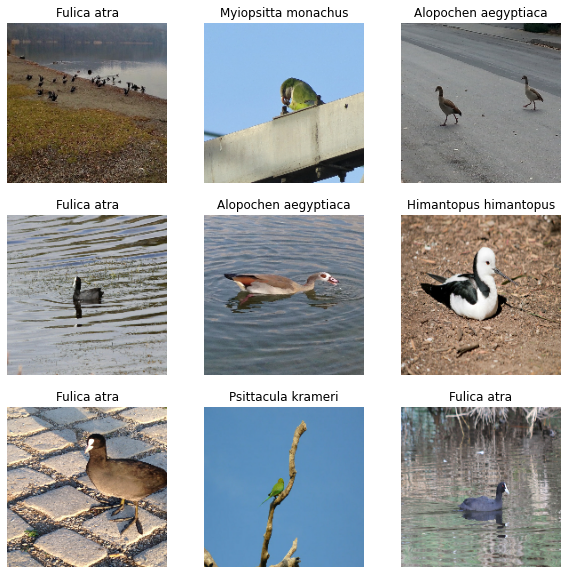

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
# poner graficos pie chart

## Configurar el conjunto de datos para el rendimiento

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Estandarización de datos
#### Actualmente las fotos estan en el rango RGB de [0, 255]. Esto no es ideal para una red neuronal, por eso hay que buscar que los valores de entrada sean mas pequeños

In [20]:
rescale_and_resize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
])

## Aumento de datos
#### El aumento de datos se hace cuando no se tiene muchos datos, ademas ayuda a corregir el overfitting

In [21]:
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
	tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
	tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

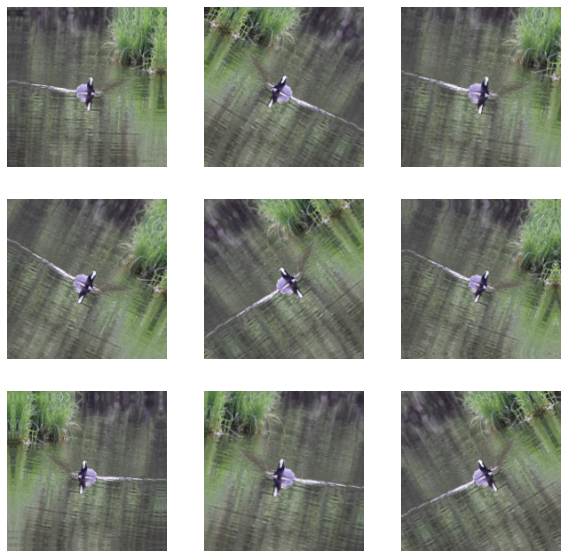

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Creación del modelo CNN

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = tf.keras.Sequential([
    rescale_and_resize,
    data_augmentation,

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),

    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 180, 180, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 180, 180, 3)         0         
                                                                 
 module_wrapper_11 (ModuleWr  (32, 180, 180, 64)       1792      
 apper)                                                          
                                                                 
 module_wrapper_12 (ModuleWr  (32, 90, 90, 64)         0         
 apper)                                                          
                                                                 
 module_wrapper_13 (ModuleWr  (32, 90, 90, 64)         36928     
 apper)                                                          
                                                      

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True) # que si ha mejorado el modelo lo guarde
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks=[early_stopping]

In [26]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/50
43/43 [==============================] - 66s 1s/step - loss: 2.1258 - accuracy: 0.1452 - val_loss: 2.0350 - val_accuracy: 0.2023
Epoch 2/50
43/43 [==============================] - 61s 1s/step - loss: 1.9975 - accuracy: 0.2229 - val_loss: 1.9821 - val_accuracy: 0.2669
Epoch 3/50
43/43 [==============================] - 63s 1s/step - loss: 1.8934 - accuracy: 0.2874 - val_loss: 1.9966 - val_accuracy: 0.2287
Epoch 4/50
43/43 [==============================] - 64s 1s/step - loss: 1.7819 - accuracy: 0.3087 - val_loss: 1.7986 - val_accuracy: 0.2962
Epoch 5/50
43/43 [==============================] - 67s 2s/step - loss: 1.7077 - accuracy: 0.3651 - val_loss: 1.7746 - val_accuracy: 0.3079
Epoch 6/50
43/43 [==============================] - 72s 2s/step - loss: 1.6232 - accuracy: 0.3922 - val_loss: 1.8153 - val_accuracy: 0.3226
Epoch 7/50
43/43 [==============================] - 60s 1s/step - loss: 1.5703 - accuracy: 0.4032 - val_loss: 1.8442 - val_accuracy: 0.2933
Epoch 8/50
43/43 [==

KeyboardInterrupt: 

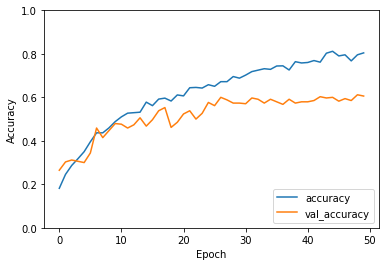

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

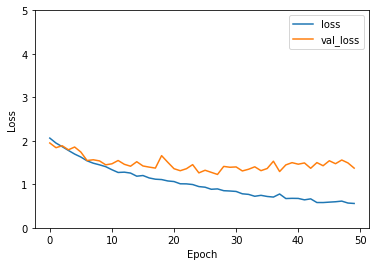

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')

In [ ]:
img = tf.keras.utils.load_img(
    'C:/Users/aritz/OneDrive/Escritorio/998f940f7f3d50c43059ef99033456b7--argentina.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

score*100


This image most likely belongs to Myiopsitta monachus with a 27.41 percent confidence.


<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([10.333708, 10.333707, 10.333707, 10.333708, 10.333707, 10.333707,
       27.40627 , 10.591485], dtype=float32)>

In [ ]:
import glob

result = []

for filename in glob.glob('C:/Users/aritz/OneDrive/Escritorio/MUUUH/3. maila/2/PBL/Descarte de fotos/Branta canadensis/*.jpg'):
    img = tf.keras.utils.load_img(
     filename, target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    result.append(class_names[np.argmax(score)])


366

In [ ]:
print(result.count('Branta canadensis'))
print(result.count('Fulica atra'))
print(result.count('Himantopus himantopus'))
print(result.count('Ciconia ciconia'))
print(result.count('Alcedo atthis'))
print(result.count('Alopochen aegyptiaca'))

542
143
112
116
61
366
